# Tutorial 10 - Diffusion Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import copy
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import tqdm
import functools
from scipy import integrate


## Data generation process

In [ ]:
def sample_x(N, sigma = 0.5, device = "cpu"):
    x = torch.empty(N, device=device)
    filled = 0

    while filled < N:
        # Oversample to make rejection efficient
        batch_size = (N - filled) * 2

        # Draw |N(0, sigma^2)| -> half-Gaussian on [0, ∞)
        z = torch.abs(torch.randn(batch_size, device=device) * sigma)

        # We only keep those that fit in [0, 1] (so that -1+z ∈ [-1,0], 1-z ∈ [0,1])
        z = z[z <= 1.0]
        if z.numel() == 0:
            continue

        # Trim to what we still need
        z = z[: (N - filled)]

        # Randomly choose left (-1+z) or right (1-z) side
        side = torch.randint(0, 2, (z.shape[0],), device=device)  # 0 = left, 1 = right
        x_batch = torch.where(side == 0, -1.0 + z, 1.0 - z)

        x[filled : filled + x_batch.shape[0]] = x_batch
        filled += x_batch.shape[0]
    return x

def sample_x_uniform(N):
    return np.random.uniform(-1,1, N)

def f_sine(x):
    return np.sin(np.pi * x) + 0.1*(1.0+2*np.abs(x))*np.random.randn(*x.shape)

def get_dataset(N, batch_size=64):
    # X = sample_x_uniform(N)
    X = sample_x(N)
    Y = f_sine(X).reshape(-1,1)
    X = X.reshape(-1,1)
    return torch.tensor(X).to("cuda").type(torch.float32), torch.tensor(Y).to("cuda").type(torch.float32)


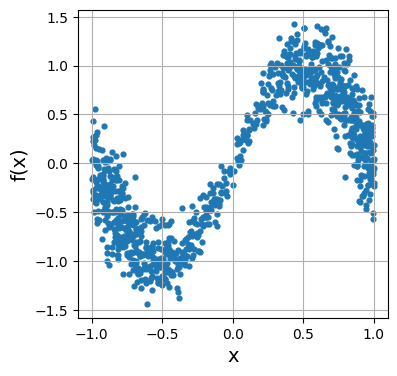

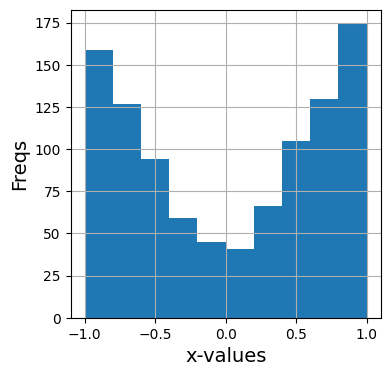

In [ ]:
X = sample_x(1000)

plt.subplots(figsize=(4, 4))
plt.scatter(X, f_sine(X), s = 12)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.grid()
plt.show()

plt.subplots(figsize=(4, 4))
plt.hist(X)
plt.xlabel("x-values", fontsize = 14)
plt.ylabel("Freqs", fontsize = 14)
plt.grid()
plt.show()


##### More variance means each sample carries more information (sample it more frequently)

## Regression Model

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class MLP(nn.Module):
    def __init__(self,
                 in_dim = 1,
                 out_dim = 1,
                 widths = [64, 128, 128, 64]):
        super(MLP, self).__init__()

        widths = [in_dim] + list(widths) + [out_dim]
        self.n_layers = len(widths) - 1
        self.layers = nn.ModuleList([nn.Linear(widths[i], widths[i+1]) for i in range(self.n_layers)])
        #self.activation = Swish()#nn.ReLU()
        self.activation = Swish()
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

#----------------------------

def train(model, optimizer, scheduler, training_loader, val_loader, epochs = 10, loss =  nn.MSELoss(), freq_print = 1, tag = ""):

    best_model_testing_error = 1000

    for epoch in range(epochs):
        train_mse = 0.0
        for step, (input_batch, output_batch) in enumerate(training_loader):
            optimizer.zero_grad()
            output_pred_batch = model(input_batch)
            loss_f = loss(output_pred_batch, output_batch)
            loss_f.backward()
            optimizer.step()
            train_mse += loss_f.item()
        train_mse /= len(training_loader)

        scheduler.step()

        with torch.no_grad():
            model.eval()
            test_relative_l2 = 0.0
            for step, (input_batch, output_batch) in enumerate(val_loader):
                output_pred_batch = model(input_batch)
                loss_f = torch.mean(torch.norm(output_pred_batch - output_batch, p=2, dim = [1]))

                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(val_loader)


        if test_relative_l2 < best_model_testing_error:
            best_model_testing_error = test_relative_l2
            best_model = copy.deepcopy(model)

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)

    return best_model


In [ ]:
batch_size = 128
N_train = 5000
N_val = 1024
N_test = 1024

inp_train, out_train = get_dataset(N_train)
inp_val, out_val = get_dataset(N_val)

#-------------

dataset_train = TensorDataset(inp_train, out_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = TensorDataset(inp_val, out_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
weight_decay = 0
step_size = 100
gamma = 0.8
epochs = 200

tag = "tmp"

model = MLP(in_dim = 1, out_dim = 1, widths = [64, 64]).to("cuda")
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=50, tag = tag)



/scratch/tmp.49761791.braonic/ipykernel_1350414/3088005452.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X).to("cuda").type(torch.float32), torch.tensor(Y).to("cuda").type(torch.float32)


######### Epoch: 0  ######### Train Loss: 0.3448204107582569  ######### Relative L1 Test Norm: 0.4406295418739319
######### Epoch: 50  ######### Train Loss: 0.05405633132904768  ######### Relative L1 Test Norm: 0.17820476926863194
######### Epoch: 100  ######### Train Loss: 0.05508437789976597  ######### Relative L1 Test Norm: 0.178991025313735
######### Epoch: 150  ######### Train Loss: 0.055844809580594304  ######### Relative L1 Test Norm: 0.1780191157013178


/scratch/tmp.49761791.braonic/ipykernel_1350414/3088005452.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X).to("cuda").type(torch.float32), torch.tensor(Y).to("cuda").type(torch.float32)


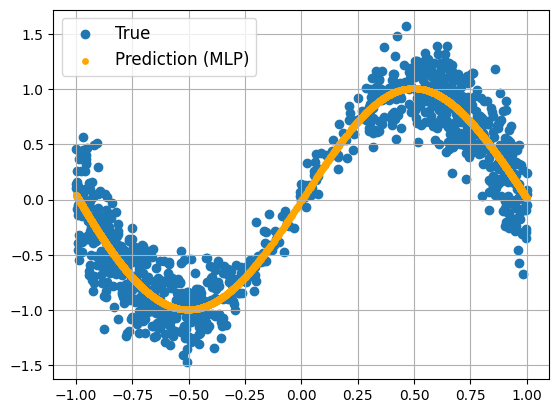

In [ ]:
inp_test, out_test = get_dataset(5000)
plt.scatter(X, f_sine(X), label = "True")
Y_pred = model(inp_test)[:,0]

plt.scatter(inp_test[:,0].detach().cpu().numpy(), Y_pred.detach().cpu().numpy(), color = "orange", label = "Prediction (MLP)", s = 15)
plt.legend(fontsize = 12)
plt.grid(True)

### The regression model is only able to capture the mean of the distribution

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Conditional Diffusion Models

#### **Goal**: Sample from a data generating distribution, conditined on the x-axis value

In a diffusion model we define a simple forward process that gradually destroys structure in the data by adding noise.  
Starting from a clean data point $x_0$, the forward SDE generates a noisy version $x(t)$ by
$$
dx = g(t)\,dw,
$$
so that the distribution of $x(t)$ becomes more and more Gaussian as $t$ increases.
For large $t$ the sample $x(t)$ is almost pure noise.

The goal of sampling is to run this process backwards: starting from noise, we want to recover a data sample.
The reverse–time SDE has the form
$$
dx = -g(t)^2 \nabla_x \log p_t(x)\,dt + g(t)\,d\bar w,
$$
which removes noise as $t$ decreases.
To simulate this backward process we need the score $\nabla_x \log p_t(x)$.
We approximate it using a neural network (the denoiser), which predicts the clean data point $\hat{x}_0$ from a noisy input $x(t)$.
From this prediction we build an estimate of the score and plug it into the reverse SDE to gradually transform noise into a realistic sample.


<div style="text-align: center; width:600px; margin:auto;">

![image.png](attachment:image-2.png)

</div>

### Diffusion Model Implementation

The neural network we train is a conditional denoiser.  
It receives three inputs:  
1. a noisy sample $x(t)$,  
2. a conditioning vector $x_{\text{cond}}$,  
3. the diffusion time $t$.  

The goal of the model is to predict the underlying clean data point $x_0$ that generated $x(t)$.
Thus the model output is denoted by $\hat{x}_0$.

For the variance–exploding diffusion process, the noisy sample is related to the clean data by
$$
x(t) = x_0 + \sigma(t) z,
\qquad z \sim \mathcal{N}(0,I),
$$
where $\sigma(t)$ is the marginal standard deviation of the forward SDE.
Because of this, predicting $x_0$ from $x(t)$ and the time $t$ is equivalent to learning the denoising function
$$
\hat{x}_0 = f_\theta(x(t),\,x_{\text{cond}},\,t).
$$

In the implementation, the inputs are concatenated as
$$
[x(t),\; x_{\text{cond}},\; \log\sigma(t)],
$$
so the network has access to the noisy sample, the conditioning information, and the noise level.
The model contains several fully–connected layers with a nonlinear activation, and produces an output that is scaled by $1/\sigma(t)$ so that the network learns the quantity
$$
\frac{x_0}{\sigma(t)},
$$
which makes training numerically stable.

During sampling, the predicted clean value $\hat{x}_0$ is used to approximate the score
$$
\nabla_x \log p_t(x) \approx \frac{\hat{x}_0 - x(t)}{\sigma(t)^2},
$$
which is then plugged into the reverse–time SDE update step.


<div style="text-align: center; width:600px; margin:auto;">

![image.png](attachment:image.png)

</div>

In [ ]:
class MLPDiffusion(nn.Module):
    def __init__(self,
                 dim = 1,
                 cond_dim = 0,
                 widths = [64, 128, 128, 64],
                 marginal_prob_std = None):
        super(MLPDiffusion, self).__init__()

        widths = [dim + 1 + cond_dim] + list(widths) + [dim]
        self.n_layers = len(widths) - 1
        self.layers = nn.ModuleList([nn.Linear(widths[i], widths[i+1]) for i in range(self.n_layers)])
        self.activation = nn.SiLU()

        self.marginal_prob_std = marginal_prob_std


    def forward(self,
                x,
                x_cond,
                diffusion_time):

        sigma = self.marginal_prob_std(diffusion_time)

        if sigma.dim() < 1:
            sigma = sigma.expand(x.shape[0])

        if x_cond is not None:
            x = torch.cat((x, x_cond, torch.log(sigma)[:, None]), dim=1)
        else:
            x = torch.cat((x, torch.log(sigma)[:, None]), dim=1)


        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x/sigma[:,None]

### Diffusion Scheme

We use the variance–exploding (VE) SDE parameterized by a noise growth factor $\sigma > 1$.
The forward SDE is
$$
dx = g(t)\,dw,
$$
where the diffusion coefficient is chosen as
$$
g(t) = \sigma^{\,t}.
$$

The corresponding marginal distribution of $x(t)$ under the VE SDE has variance
$$
\operatorname{Var}[x(t)] = \frac{\sigma^{2t} - 1}{2\log\sigma}.
$$
Therefore the marginal standard deviation used in the sampler is
$$
\sigma(t) = \sqrt{\frac{\sigma^{2t} - 1}{2\log\sigma}}.
$$

The function **marginal\_prob\_std\_1** computes this quantity

  
The function **diffusion\_coeff\_1** returns the diffusion coefficient
$$
g(t) = \sigma^{\,t}.
$$

Together, $\sigma(t)$ and $g(t)$ fully determine the forward SDE and the reverse–time SDE used for sampling.


In [ ]:
def marginal_prob_std_1(t, sigma, device = "cpu"):
    """
    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff_1(t, sigma, device = "cpu"):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)


In [ ]:
T = torch.linspace(0,1,200)
S = marginal_prob_std_1(T, sigma = 100.)
plt.subplots(figsize=(4, 4))
plt.plot(T.numpy(),S.numpy(), linewidth = 5)
plt.xlabel('Diffusion Time', fontsize = 14)
plt.ylabel(r'$\sigma(t)$', fontsize = 14)
plt.grid()
plt.show()

### Loss function

We pick a random time $t$ and add noise
$$
x(t) = x + \sigma(t)\,z,\qquad z\sim\mathcal{N}(0,I).
$$
The model sees $x(t)$, $x_{\text{cond}}$, and $t$, and predicts the clean data $\hat{x}_0$.
The loss is just
$$
\mathcal{L} = \lVert \hat{x}_0 - x\rVert^2,
$$
which trains the network to denoise $x(t)$ back to $x$.


In [ ]:
def loss_fn(model,
            x,
            x_cond,
            marginal_prob_std = None,
            eps= 1e-6,
            is_train = True):

        if is_train:
                random_t = torch.rand(x.shape[0], device=x.device) + eps
                z = torch.randn_like(x, device = x.device)
                std = marginal_prob_std(random_t)
                denoised = model(x + z * std[:, None], x_cond, random_t)

                x_squared = torch.square(x)
                denoise_squared = torch.square(denoised)
                loss = torch.mean(torch.square(denoised - x))
                return loss
        else:
                err_val = 0
                for level in range(8):
                        t_min = level/8.0
                        t_max = (level + 1)/8.0
                        random_t = (torch.rand(x.shape[0], device=x.device)+eps)*(t_max-t_min)+t_min

                        z = torch.randn_like(x)
                        std = marginal_prob_std(random_t)

                        denoised = model(x + z * std[:, None], x_cond, random_t)
                        loss = torch.mean(torch.square(denoised - x))
                        err_val = err_val + loss
                return err_val/8.0

## Train Conditional-Diffusion Model

In [ ]:
learning_rate = 0.0005
step_size = 50
gamma = 0.95
epochs = 2001
device = "cuda"

tqdm_epoch = tqdm.trange(epochs)

save_epochs = [100, 200, 500, 1000, 2000]

N_train = 5000
inp_train, out_train = get_dataset(N_train)
inp_val, out_val = get_dataset(N_val)
dataloader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=256, shuffle=False)


cond_dim = 1
in_dim = 1
sigma = 100.
widths = [256, 512, 512, 512, 256]

marginal_prob_std_fn = functools.partial(marginal_prob_std_1, sigma=sigma, device = device)
diffusion_coeff_fn = functools.partial(diffusion_coeff_1, sigma=sigma, device = device)

model_diff = MLPDiffusion(widths = widths, marginal_prob_std = marginal_prob_std_fn, cond_dim=cond_dim, dim=in_dim).to("cuda")
optimizer = AdamW(model_diff.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

best_avg_loss = 1000.
best_model_diff = None


for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    model_diff.train()

    for i, (input_batch, output_batch) in enumerate(dataloader_train):
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)

        loss = loss_fn(model_diff, output_batch, input_batch, marginal_prob_std_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() * output_batch.shape[0]
        num_items += output_batch.shape[0]

    avg_loss /= num_items
    scheduler.step()

    model_diff.eval()
    avg_loss_val = 0.
    num_items = 0
    with torch.no_grad():
        for input_batch, output_batch in dataloader_val:
            input_batch = input_batch.to(device)
            output_batch = output_batch.to(device)
            loss = loss_fn(model_diff, output_batch, input_batch, marginal_prob_std_fn, is_train=False)
            avg_loss_val += loss.item() * output_batch.shape[0]
            num_items += output_batch.shape[0]
    avg_loss_val /= num_items
    if avg_loss_val<best_avg_loss:
      best_avg_loss = avg_loss_val
      best_model_diff = copy.deepcopy(model_diff)

    if epoch in save_epochs:
      torch.save(best_model_diff.state_dict(), f"saved_models/diff_model1d_ep_5k_samples_{epoch}.pth")

    if epoch%10 == 0:
      tqdm_epoch.set_description('Train: {:.5f} Val: {:.5f}'.format(avg_loss, avg_loss_val))



### Euler-Maruyama Sampler

We train a denoising model that, given a noisy sample $x(t)$ at time $t$, predicts the underlying clean data point.
Its output is denoted by $\hat{x}_0$.

The variance–exploding forward SDE is
$$
dx = g(t)\,dw,
$$
where $g(t)$ is the diffusion coefficient of the forward process, and
$\sigma(t)$ (called std in the code) is the marginal standard deviation of $x(t)$.

The reverse–time SDE that we simulate for sampling is
$$
dx = -g(t)^2 \nabla_x \log p_t(x)\,dt + g(t)\,d\bar w.
$$

Because the forward corruption process satisfies
$$
x(t)\mid x_0 \sim \mathcal{N}(x_0,\,\sigma(t)^2 I),
$$
the gradient of the log–density (the score) is
$$
\nabla_x \log p(x(t)\mid x_0) = \frac{x_0 - x(t)}{\sigma(t)^2}.
$$

Since the denoising model predicts $\hat{x}_0 \approx x_0$, we approximate the score by
$$
\nabla_x \log p_t(x) \approx \frac{\hat{x}_0 - x}{\sigma(t)^2}.
$$

Plugging this into the reverse–time SDE gives the Euler–Maruyama update
$$
x_{k+1}
=
x_k
-
g(t_k)^2
\frac{\hat{x}_0 - x_k}{\sigma(t_k)^2}\,\Delta t
+
g(t_k)\sqrt{-\Delta t}\,\xi_k,
\qquad
\xi_k \sim \mathcal{N}(0,I),
$$
which is exactly the update implemented in the sampler.


In [ ]:
def Euler_Maruyama_sampler(model,
                           marginal_prob_std,
                           diffusion_coeff,
                           condition,
                           device="cpu",
                           num_steps=128,
                           dimension=(1,),
                           min_t=1e-2):
    # Use the model's device
    device = next(model.parameters()).device

    # Handle condition & batch size
    if condition is not None:
        condition = condition.to(device)
        batch_size = condition.shape[0]
    else:
        batch_size = 64
        cond_dim = getattr(model, "cond_dim", 0)
        if cond_dim > 0:
            condition = torch.zeros(batch_size, cond_dim, device=device)
        else:
            condition = None

    # Start from t = 1 with N(0, sigma(1)^2 I)
    t0 = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, dimension[0], device=device) * marginal_prob_std(t0)[:, None]

    # Time goes from 1 -> min_t (decreasing)
    time_steps = torch.linspace(1., min_t, num_steps, device=device)
    # IMPORTANT: dt is NEGATIVE now
    dt = time_steps[1] - time_steps[0]  # < 0
    x = init_x

    model.eval()
    with torch.no_grad():
        for time_step in time_steps:
            batch_t = torch.ones(batch_size, device=device) * time_step

            g   = diffusion_coeff(batch_t)         # (B,)
            std = marginal_prob_std(batch_t)       # (B,)

            # Denoiser -> score
            denoised = model(x, condition, batch_t)   # predicts clean x_0
            score = (denoised - x) / (std[:, None] ** 2)

            # Reverse-time SDE: dx = (f - g^2 * score) dt + g dW, f=0
            drift = -(g ** 2)[:, None] * score

            noise = torch.randn_like(x)
            x = x + drift * dt + g[:, None] * torch.sqrt(-dt) * noise

    return x


## Test Conditional-Diffusion Model

### Task 1

- The code loads a pretrained diffusion model and generates samples conditioned on test inputs.
- It then plots these samples against the true function to show how well the model learned the data.

In [ ]:
device = "cpu"
sigma = 100.
cond_dim = 1
dim = 1
widths = [256, 512, 512, 512, 256]

marginal_prob_std_fn = functools.partial(marginal_prob_std_1, sigma=sigma, device = device)
diffusion_coeff_fn = functools.partial(diffusion_coeff_1, sigma=sigma, device = device)

path = "saved_models/diff_model1d_ep_5k_samples_2000.pth"
model_best = MLPDiffusion(widths = widths, marginal_prob_std = marginal_prob_std_fn, cond_dim=cond_dim, dim=dim).to(device)
model_best.load_state_dict(torch.load(path, map_location=device, weights_only=True))
model_best.eval()

model_best = model_best.eval()

inp_test, out_test = get_dataset(512)
samples = Euler_Maruyama_sampler(
                                model_best.eval(),
                                marginal_prob_std_fn,
                                diffusion_coeff_fn,
                                condition=inp_test,
                                device=device,   # or just omit; function infers from model
                                dimension=(1,),
                                # TODO 2: Change num_steps (e.g. 32, 64, 128, 256, 512) and observe how the samples change.
                                num_steps=32,   # TODO 2
                                min_t=1e-2)
X = np.linspace(-1,1,512)
plt.scatter(X, f_sine(X),  color = "red", label = "Ground Truth", s = 5)
plt.scatter(inp_test[:,0].detach().cpu().numpy(),samples[:,0].detach().cpu().numpy(), color = "blue", s = 5, label = "Sampled")
plt.grid()

plt.xlim([-1.05,1.05])
plt.ylim([-1.5,1.5])
plt.legend(fontsize=14)

plt.xlabel("x",fontsize=14)
plt.ylabel("f(x)",fontsize=14)
plt.show()



### Task 2


- The code generates many conditional samples from the trained diffusion model at different input locations.
- Then it compares the empirical mean and standard deviation of these samples to the true data-generating mean and noise level.

In [ ]:
# Compare empirical std of generated samples to the data-generating noise std
# y = sin(pi * x) + 0.1 * (1 + 2 * |x|) * N(0, 1)

import torch
import numpy as np

device = next(model_best.parameters()).device

# Positions at which we check the conditional distribution
x_positions = torch.linspace(-1.0, 1.0, 21, device=device).view(-1, 1)
num_mc_samples = 512  # number of samples per x

print("x      | mean_hat      mean_true     std_hat      std_true")
print("---------------------------------------------------------------")

mean_gt = []
mean_pred = []

std_gt = []
std_pred = []

for x0 in x_positions:
    # Repeat the same x0 many times as conditioning input
    cond = x0.view(1, 1).repeat(num_mc_samples, 1).to(device)

    # Generate samples from the diffusion model
    samples = Euler_Maruyama_sampler(
        model_best.eval(),
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        condition=cond,
        device=device,
        dimension=(1,),
        num_steps=128,
        min_t=1e-2,
    )
    # samples shape: (num_mc_samples, 1)

    # Move to CPU and convert to numpy for stats
    y_samples = samples[:, 0].detach().cpu().numpy()

    # Theoretical mean and std from the data-generating process

    # TODO 1: Compute the true mean at this x0 for the data-generating process
    # y = sin(pi * x) + 0.1 * (1 + 2 * |x|) * N(0, 1)
    mean_true = 0.0  # TODO 1: replace with the correct expression

    # TODO 2: Compute the true standard deviation of the noise at this x0
    std_true = 1.0   # TODO 2: replace with the correct expression

    # TODO 3: Compute the sample mean
    mean_hat = 0.0  # TODO 1: replace with the correct expression

    # TODO 4: Compute the sample std
    std_hat = 1.0   # TODO 2: replace with the correct expression

    print(f"{x0_scalar:+.2f}  | {mean_hat:+.6f}  {mean_true:+.6f}  {std_hat:+.6f}  {std_true:+.6f}")



### Task 3

- The code generates samples at several input values using different numbers of solver steps
- It measures how far their mean and standard deviation are from the true ones.
- Then, it plots how these errors decrease as the number of reverse-time SDE steps increases.

In [ ]:
device = next(model_best.parameters()).device

# Evaluation points
x_eval = torch.tensor([[-0.5], [0.0], [0.5]], device=device)

# Number of MC samples for estimating mean and std
num_mc_samples = 512

# Range of num_steps to test
num_steps_list = [4, 8, 16, 32, 64, 128, 256, 512]

# Containers for storing errors
mean_errors = {float(x.item()): [] for x in x_eval}
std_errors  = {float(x.item()): [] for x in x_eval}

for ns in num_steps_list:
    for x0 in x_eval:
        cond = x0.view(1, 1).repeat(num_mc_samples, 1).to(device)

        samples = Euler_Maruyama_sampler(
            model_best.eval(),
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            condition=cond,
            device=device,
            dimension=(1,),
            num_steps=ns,
            min_t=1e-2,
        )

        y_samples = samples[:, 0].detach().cpu().numpy()
        x0_scalar = float(x0.item())

        # true mean / std
        mean_true = np.sin(np.pi * x0_scalar)
        std_true  = 0.1 * (1.0 + 2.0 * np.abs(x0_scalar))

        # empirical
        mean_hat = y_samples.mean()
        std_hat  = y_samples.std()

        # store errors
        mean_errors[x0_scalar].append(abs(mean_hat - mean_true))
        std_errors[x0_scalar].append(abs(std_hat - std_true))

        # TODO  : Instead of absolute error, compute and store RELATIVE errors
        # mean_errors[x0_scalar].append(...)
        # std_errors[x0_scalar].append(...)

        print(f"Done ns = {ns}, x0 = {x0}")

print("Done computing errors.")

# ---------------------------
# Plot mean error vs num_steps
# ---------------------------

plt.figure(figsize=(8, 5))
for x0_scalar in mean_errors:
    plt.plot(num_steps_list, mean_errors[x0_scalar], marker="o", label=f"x={x0_scalar:+.2f}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("num_steps (log scale)")
plt.ylabel("Absolute mean error (log scale)")
plt.title("Mean Error vs num_steps")
plt.grid(True)
plt.legend()
plt.show()

# ---------------------------
# Plot std error vs num_steps
# ---------------------------

plt.figure(figsize=(8, 5))
for x0_scalar in std_errors:
    plt.plot(num_steps_list, std_errors[x0_scalar], marker="o", label=f"x={x0_scalar:+.2f}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("num_steps (log scale)")
plt.ylabel("Absolute std error (log scale)")
plt.title("Std Error vs num_steps")
plt.grid(True)
plt.legend()
plt.show()


### Task 4

- The code loads several model checkpoints trained for different numbers of epochs
- It generates samples conditioned on various input values.
- For each checkpoint, it measures how far the sampled mean and standard deviation are from the true ones, letting you compare model quality over training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Common diffusion setup
# -----------------------------
cond_dim = 1
widths = [256, 512, 512, 512, 256]
dim = 1

# TODO 1: Change sigma (e.g., try 50 or 200) and observe how checkpoint performance changes.
sigma = 100.0

marginal_prob_std_fn = functools.partial(marginal_prob_std_1, sigma=sigma, device=device)
diffusion_coeff_fn   = functools.partial(diffusion_coeff_1,   sigma=sigma, device=device)

# Checkpoints and path template
checkpoint_epochs = [100, 200, 500, 1000, 2000]
path_template = "saved_models/diff_model1d_ep_5k_samples_{}.pth"

# Evaluation points and MC setup
x_eval = torch.tensor([[-0.75], [-0.5], [0.0], [0.5], [0.75]], device=device)   # shape (3, 1)
num_mc_samples = 512

# TODO 2: Change num_steps (e.g., 32, 64, 256) and compare how earlier vs. later checkpoints behave.
num_steps = 128

# Containers: errors[epoch][x_value] = error
mean_errors = {epoch: [] for epoch in checkpoint_epochs}
std_errors  = {epoch: [] for epoch in checkpoint_epochs}

for epoch in checkpoint_epochs:
    print(f"\nEvaluating checkpoint at epoch {epoch}...")
    # Load model for this checkpoint
    path = path_template.format(epoch)
    model = MLPDiffusion(
        widths=widths,
        marginal_prob_std=marginal_prob_std_fn,
        cond_dim=cond_dim,
        dim=dim
    ).to(device)
    state = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(state)
    model.eval()

    for x0 in x_eval:
        # Repeat x0 many times as conditioning input
        cond = x0.view(1, 1).repeat(num_mc_samples, 1).to(device)

        # Sample from the diffusion model
        samples = Euler_Maruyama_sampler(
            model.eval(),
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            condition=cond,
            device=device,
            dimension=(1,),
            num_steps=num_steps,
            min_t=1e-2,
        )

        y_samples = samples[:, 0].detach().cpu().numpy()
        x0_scalar = float(x0.item())

        # True mean and std from the data-generating process:
        # y = sin(pi * x) + 0.1 * (1 + 2 * |x|) * N(0, 1)
        mean_true = np.sin(np.pi * x0_scalar)
        std_true  = 0.1 * (1.0 + 2.0 * np.abs(x0_scalar))

        mean_hat = y_samples.mean()
        std_hat  = y_samples.std()

        mean_err = abs(mean_hat - mean_true)
        std_err  = abs(std_hat - std_true)

        mean_errors[epoch].append(mean_err)
        std_errors[epoch].append(std_err)

        print(
            f"  x = {x0_scalar:+.2f} | "
            f"mean_hat = {mean_hat:+.5f}, mean_true = {mean_true:+.5f}, "
            f"std_hat = {std_hat:.5f}, std_true = {std_true:.5f}"
        )


#### Bonus exercise: What happens if the training x-values are sampled uniformly (using sample_x_uniform) instead of being concentrated near −1 and 1 as in sample_x?